<a href="https://colab.research.google.com/github/codiak/DTSA-5511/blob/main/DTSA_5511_Kaggle_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets
### Kaggle project as part of CU Boulder DTSA-5511

"Deep Learning" class participation in the Kaggle competition:
[Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)

This project's goal is to identify tweets referencing a _real_ disaster, through the use of NLP techniques and a model architecture in the RNN family.

Completed by Cody P (@codiak).

Github repo: https://github.com/codiak/DTSA-5511

In [ ]:
# Import necessary libraries
!pip install kaggle
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# data cleaning
!pip install twokenize
import html
import re, os
import string
import sys
import twokenize

# encoding
from gensim.models import Word2Vec
import numpy as np
from keras.preprocessing.sequence import pad_sequences

### Data Fetching

Using the Kaggle API to import the dataset.

In [ ]:
!mkdir -p ~/.kaggle
!cp /kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 749kB/s]
100% 593k/593k [00:00<00:00, 749kB/s]


In [ ]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis

In [ ]:
train_df.sample(5)

,id,keyword,location,text,target
3087,4430,electrocute,Here.,Let her go - Passenger,0
7256,10387,whirlwind,Somewhere between here & there,I stand alone\ndon't piss and moan\nabout my c...,0
2018,2896,damage,Australia,Thank you @RicharkKirkArch @AusInstArchitect f...,0
805,1168,blight,"Cleveland, OH",Look for my Policy Matters Ohio report on #CLE...,0
3142,4516,emergency,"Based out of Portland, Oregon",@newyorkcity for the #international emergency ...,0


In [ ]:
test_df.sample(5)

,id,keyword,location,text
948,3143,debris,NaN,With authorities ???increasingly confident??? ...
778,2567,crash,"Austin, TX",lol at the guy whipping by me on a double yell...
1410,4647,emergency%20services,"Bodmin, Cornwall",@bodminmoor1 experienced the expertise of some...
869,2848,cyclone,"Mansfield, Ohio",#LocalEventCountdown:\n8. Curtain opens on The...
2961,9804,trapped,Orlando,It's a trap not a fucking game. U ain't trappi...


Test dataset does not include labels, so training and validation will need to only use train_df.

Let's take a look at the distribution of train_df

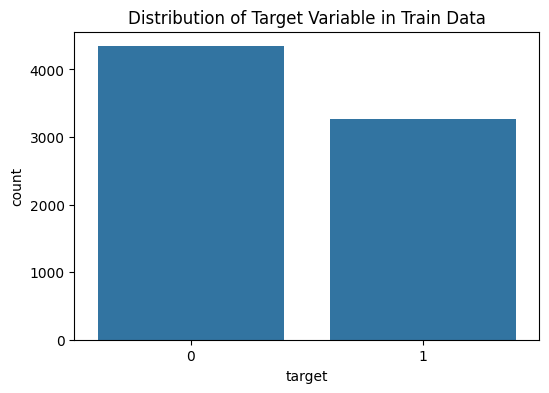

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable in Train Data')
plt.show()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


There is a pretty even mix of negative and positive samples.
The keyword data might need some cleaning. Looking at top occurring keyword values may offer insight.

<Axes: title={'center': 'Top Keywords by Count'}, xlabel='keyword', ylabel='count'>

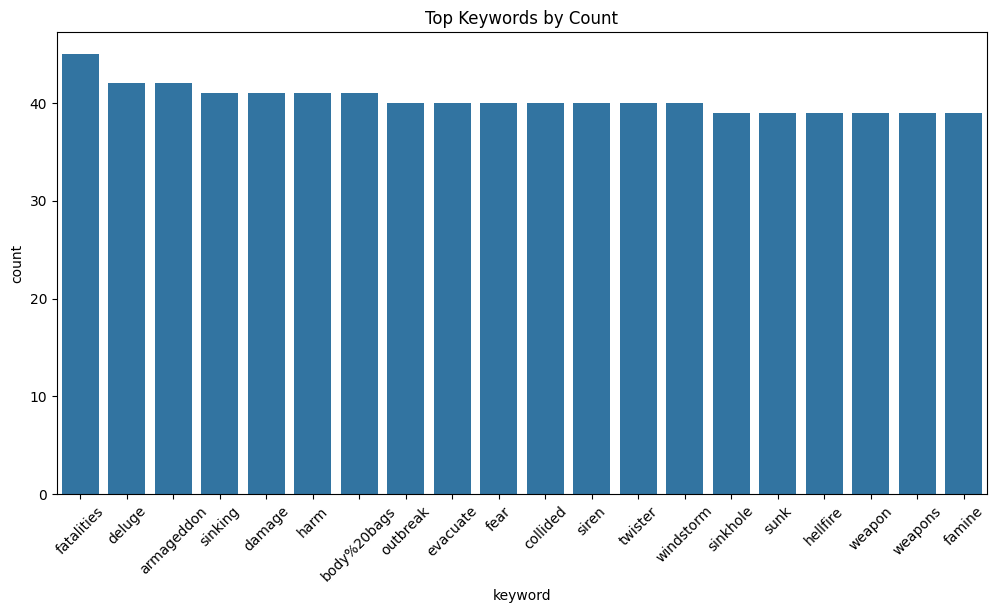

In [ ]:
keyword_values = list(train_df['keyword'].value_counts())

# Graph counts of keywords
plt.figure(figsize=(12, 6))
plt.title('Top Keywords by Count')
plt.xticks(rotation=45)
sns.countplot(x='keyword', data=train_df, order=train_df['keyword'].value_counts().index[:20])

### Data Cleaning

The tweet contents need to be stripped of strange formatting and platform specific syntax that does not have semantical meaning.

In this case I have taken and adapted a cleaning function from a similar project.

The strings will then need to be tokenized in order to use as features (whether as embeddings or encodings).

In [ ]:
# Updated version of cleaning function from:
# https://github.com/CrisisNLP/deep-learning-for-big-crisis-data/blob/master/data_helpers/preprocess.py
# Handles multiple cases found in the dataset such URL fragments, Twitter specific syntax, and internet slang such as ":)" and "lol"
# Twokenize for reference: https://pypi.org/project/twokenize/

def cleanAndTokenize(tweet):
    # addition: html pre-step
    tweet = html.unescape(tweet)

    tweet = tweet.strip(' \t\n\r')
    # 1. Lowercasing
    tweet = tweet.lower()
    # Clean spaces
    tweet = re.sub(' +',' ',tweet)
    # 2. Normalizing digits
    tweet_words = tweet.strip('\r').split(' ')
    for word in [word for word in tweet_words if word.isdigit()]:
      tweet = tweet.replace(word, "D" * len(word))
    # 3. Normalizing URLs
    tweet_words = tweet.strip('\r').split(' ')
    # simplified to match http:// or https:// or any other protocol
    for word in [word for word in tweet_words if '://' in word and len(word) > 3]:
      tweet = tweet.replace(word, "httpAddress")
    # 4. Normalizing username
    tweet_words = tweet.strip('\r').split(' ')
    for word in [word for word in tweet_words if word[0] == '@' and len(word) > 1]:
      tweet = tweet.replace(word, "usrId")
    # 5. Removing special Characters
    punc = '@$%^&*()_+-={}[]:"|\'\~`<>/,'
    # trans = string.maketrans(punc, ' '*len(punc))
    # updated for Python 3.9:
    tweet = tweet.translate(str.maketrans(punc, ' '*len(punc)))
    # 6. Normalizing +2 elongated char
    tweet = re.sub(r"(.)\1\1+",r'\1\1', tweet)
    # 7. tokenization using tweetNLP
    tokens = twokenize.simpleTokenize(tweet)
    #8. fix \n char
    # tweet = tweet.replace('\n', ' ')
    return tokens

# example
cleanAndTokenize("@CHold ironically RSL call their stadium the Riot https://www.nytimes.com...")

['usrId',
 'ironically',
 'rsl',
 'call',
 'their',
 'stadium',
 'the',
 'riot',
 'httpAddress']

In [ ]:
# map each value in "text" column to a new "clean_text" using cleanAndTokenize
train_df['clean_tokens'] = train_df['text'].apply(cleanAndTokenize)
test_df['clean_tokens'] = test_df['text'].apply(cleanAndTokenize)

Review transformed/cleaned text values.

In [ ]:
# Review cleaning
train_df.sample(10).loc[:, ['text', 'clean_tokens']]

,text,clean_tokens
2102,RSS: Judge orders Texas to recognize spouse on...,"[rss, judge, orders, texas, to, recognize, spo..."
656,@audacityjamesta Don't be like that babes &lt;...,"[usrId, don, t, be, like, that, babes, 3, you,..."
5062,anyway 2 me? Mateo just doesnt exist? Hes a mi...,"[anyway, D, me, ?, mateo, just, doesnt, exist,..."
3501,New Explosion-proof Tempered Glass Screen Prot...,"[new, explosion, proof, tempered, glass, scree..."
7070,Tt kettlebell upheaval blueprint over chris lo...,"[tt, kettlebell, upheaval, blueprint, over, ch..."
5416,People are finally panicking about cable TV ht...,"[people, are, finally, panicking, about, cable..."
1159,Japan marks 70th anniversary of Hiroshima atom...,"[japan, marks, 70th, anniversary, of, hiroshim..."
4344,[Latest Post] Bayelsa poll: Tension in Bayelsa...,"[latest, post, bayelsa, poll, tension, in, bay..."
6856,Butt Trauma Extraordinaire,"[butt, trauma, extraordinaire]"
6402,Islamic State claims suicide bombing at Saudi ...,"[islamic, state, claims, suicide, bombing, at,..."


## Data Preparation for Training

Now that I have clean word/character tokens, the final step is to turn those tokens into values usable by a model. In this case I am using Word2Vec to transform them into an embedding space.

In [ ]:
# Create a Word2Vec model using the clean_text column
wv_model = Word2Vec(train_df['clean_tokens'], vector_size=512, window=7, min_count=1, workers=8, sg=0)

# Create a dictionary to map words to their corresponding word vectors
word2vec_dict = {}
for word, vector in zip(wv_model.wv.index_to_key, wv_model.wv.vectors):
    word2vec_dict[word] = vector

# Create a function to encode a word using the Word2Vec model
def word2vec_encoder(word):
    if word in word2vec_dict:
        return word2vec_dict[word]
    else:
        return np.zeros(wv_model.vector_size)

# Encode the clean_text column using the word2vec_encoder function
train_df['encoded_text'] = train_df['clean_tokens'].apply(lambda x: [word2vec_encoder(word) for word in x])
test_df['encoded_text'] = test_df['clean_tokens'].apply(lambda x: [word2vec_encoder(word) for word in x])


In [ ]:
# preview encoded values
train_df.sample(10).loc[:, ['clean_tokens', 'encoded_text']]

,clean_tokens,encoded_text
4992,"[online, infantryman, experimental, military, ...","[[0.0788788, -0.041105404, -0.090082504, 0.031..."
4786,"[shawie17shawie, breaking, news, !, unconfirme...","[[0.0020110344, -0.0010184847, 0.00045249387, ..."
1449,"[rt, usrId, documenting, climate, change, s, f...","[[0.26618433, -0.13748275, -0.2957394, 0.10602..."
4484,"[one, year, on, from, the, sinjar, massacre, #...","[[0.2733531, -0.14330722, -0.31306812, 0.10360..."
64,"[#nowplaying, rene, ablaze, ian, buff, magnitu...","[[0.071737364, -0.03803606, -0.07792401, 0.030..."
7220,"[i, m, sorry, but, if, you, have, to, resort, ...","[[0.39150512, -0.24506932, -0.5173267, 0.13804..."
3239,"[men, escape, car, engulfed, in, flames, in, p...","[[0.09466048, -0.045543473, -0.1035681, 0.0363..."
5230,"[why, did, god, order, obliteration, of, ancie...","[[0.1911212, -0.10556527, -0.22872224, 0.07374..."
6833,"[i, trapped, this, cat, in, my, room, and, it,...","[[0.39150512, -0.24506932, -0.5173267, 0.13804..."
1364,"[you, picture, buildings, burning, to, the, gr...","[[0.33525747, -0.20955352, -0.45857018, 0.1226..."


The last step of preparing the features is to pad the feature arrays so that they are all the same length (required for use in LSTM).

In [ ]:
# pad sequencees to enable training with LSTM
# Referencing: https://keras.io/api/data_loading/timeseries/

max_length = max([len(x) for x in train_df['encoded_text'].tolist()])  # Ensure you convert the series to a list

# Pad the sequences and directly update the DataFrame columns
train_df['encoded_text'] = list(pad_sequences(train_df['encoded_text'].tolist(), maxlen=max_length, padding='post'))
test_df['encoded_text'] = list(pad_sequences(test_df['encoded_text'].tolist(), maxlen=max_length, padding='post'))

# Prepare the target variable
y_train = train_df['target'].values

# Prepare the input data by converting the lists in 'encoded_text' to a numpy array
X_train = np.array(train_df['encoded_text'].tolist())
X_test = np.array(test_df['encoded_text'].tolist())

## Model Training

Using the Keras library to build an LSTM network, I will train different architecture configurations to determine an optimal solution.

In [ ]:
# Defining the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model architecture based on:
# https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47

lstm_units = 256
vector_size = 512
batch_size = 32
learning_rate = 0.001
# input is already tokenized and embedded by Word2vec with a dimension of 128
vocab_size, embed_dim = wv_model.wv.vectors.shape

model = Sequential()
model.add(LSTM(lstm_units, input_shape=(max_length, vector_size), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, input_shape=(vector_size, 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=learning_rate),metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 256)           787456    
                                                                 
 dropout (Dropout)           (None, 36, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 984705 (3.76 MB)
Trainable params: 984705 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


First training

In [ ]:
m1_history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,  # Number of epochs to train for
                    validation_split=0.2)  # Use part of the training data for validation

Epoch 1/10
191/191 [==============================] - 2s 10ms/step - loss: 0.6105 - accuracy: 0.6749 - val_loss: 0.6149 - val_accuracy: 0.6717
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6078 - accuracy: 0.6790 - val_loss: 0.6205 - val_accuracy: 0.6724
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.6023 - accuracy: 0.6842 - val_loss: 0.6069 - val_accuracy: 0.6776
Epoch 4/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6072 - accuracy: 0.6808 - val_loss: 0.6111 - val_accuracy: 0.6605
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.5986 - accuracy: 0.6910 - val_loss: 0.6091 - val_accuracy: 0.6684
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.5973 - accuracy: 0.6806 - val_loss: 0.6295 - val_accuracy: 0.6553
Epoch 7/10
191/191 [==============================] - 2s 8ms/step - loss: 0.5942 - accuracy: 0.6906 - val_loss: 0.6235 - val_accuracy: 0.6599
Epoc

In [ ]:
# graph train and validation loss
def graph_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

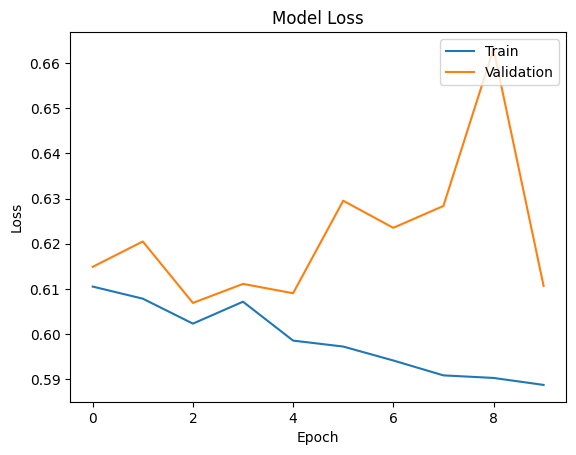

In [ ]:
graph_loss(m1_history)

In [ ]:
# add another layer, more drop out, larger batches
model2 = Sequential()
model2.add(LSTM(lstm_units, input_shape=(max_length, vector_size), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128, input_shape=(vector_size, 1), return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(64, input_shape=(128, 1), return_sequences=False))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=learning_rate),metrics = ['accuracy'])

m2_history = model2.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2)

Epoch 1/10
191/191 [==============================] - 8s 18ms/step - loss: 0.6555 - accuracy: 0.6186 - val_loss: 0.6490 - val_accuracy: 0.6014
Epoch 2/10
191/191 [==============================] - 2s 12ms/step - loss: 0.6363 - accuracy: 0.6468 - val_loss: 0.6240 - val_accuracy: 0.6619
Epoch 3/10
191/191 [==============================] - 2s 11ms/step - loss: 0.6342 - accuracy: 0.6519 - val_loss: 0.6255 - val_accuracy: 0.6586
Epoch 4/10
191/191 [==============================] - 2s 11ms/step - loss: 0.6296 - accuracy: 0.6601 - val_loss: 0.6158 - val_accuracy: 0.6658
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.6240 - accuracy: 0.6658 - val_loss: 0.6235 - val_accuracy: 0.6638
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.6246 - accuracy: 0.6657 - val_loss: 0.6279 - val_accuracy: 0.6481
Epoch 7/10
191/191 [==============================] - 2s 11ms/step - loss: 0.6213 - accuracy: 0.6709 - val_loss: 0.6181 - val_accuracy: 0.6638

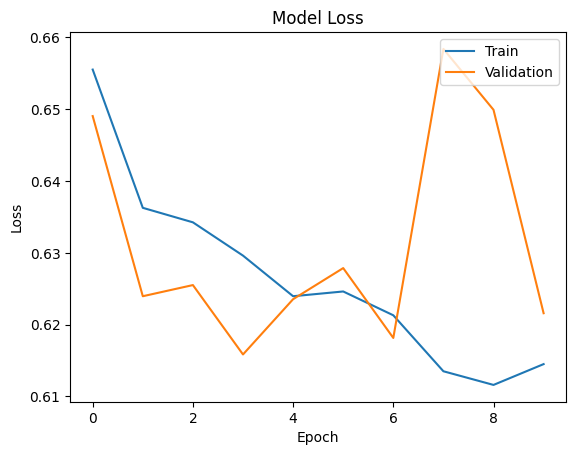

In [ ]:
graph_loss(m2_history)

In [ ]:
model3 = Sequential()
model3.add(LSTM(lstm_units, input_shape=(max_length, vector_size), return_sequences=True))
model3.add(LSTM(128, input_shape=(vector_size, 1), return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(128, input_shape=(128, 1), return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(32, input_shape=(128, 1), return_sequences=False))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

m3_history = model3.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2)

Epoch 1/10
191/191 [==============================] - 9s 21ms/step - loss: 0.6453 - accuracy: 0.6388 - val_loss: 0.6292 - val_accuracy: 0.6520
Epoch 2/10
191/191 [==============================] - 3s 13ms/step - loss: 0.6321 - accuracy: 0.6571 - val_loss: 0.6281 - val_accuracy: 0.6684
Epoch 3/10
191/191 [==============================] - 3s 13ms/step - loss: 0.6383 - accuracy: 0.6453 - val_loss: 0.6412 - val_accuracy: 0.6619
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.6260 - accuracy: 0.6660 - val_loss: 0.6193 - val_accuracy: 0.6671
Epoch 5/10
191/191 [==============================] - 2s 13ms/step - loss: 0.6239 - accuracy: 0.6616 - val_loss: 0.6092 - val_accuracy: 0.6743
Epoch 6/10
191/191 [==============================] - 2s 13ms/step - loss: 0.6149 - accuracy: 0.6739 - val_loss: 0.6079 - val_accuracy: 0.6802
Epoch 7/10
191/191 [==============================] - 3s 14ms/step - loss: 0.6121 - accuracy: 0.6773 - val_loss: 0.6300 - val_accuracy: 0.6415

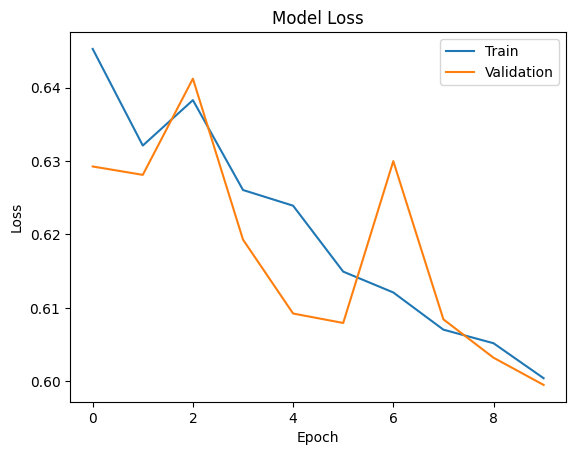

In [ ]:
graph_loss(m3_history)

In [ ]:
model4 = Sequential()
model4.add(LSTM(lstm_units, input_shape=(max_length, vector_size), return_sequences=True))
model4.add(LSTM(128, input_shape=(vector_size, 1), return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(128, input_shape=(128, 1), return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(32, input_shape=(128, 1), return_sequences=False))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

m4_history = model4.fit(X_train, y_train,
                    batch_size=32,
                    epochs=25,
                    validation_split=0.2)

Epoch 1/25
191/191 [==============================] - 12s 23ms/step - loss: 0.6467 - accuracy: 0.6317 - val_loss: 0.6276 - val_accuracy: 0.6553
Epoch 2/25
191/191 [==============================] - 2s 13ms/step - loss: 0.6297 - accuracy: 0.6547 - val_loss: 0.6203 - val_accuracy: 0.6553
Epoch 3/25
191/191 [==============================] - 3s 14ms/step - loss: 0.6231 - accuracy: 0.6604 - val_loss: 0.6224 - val_accuracy: 0.6743
Epoch 4/25
191/191 [==============================] - 3s 13ms/step - loss: 0.6159 - accuracy: 0.6655 - val_loss: 0.6182 - val_accuracy: 0.6691
Epoch 5/25
191/191 [==============================] - 2s 13ms/step - loss: 0.6069 - accuracy: 0.6813 - val_loss: 0.6124 - val_accuracy: 0.6737
Epoch 6/25
191/191 [==============================] - 2s 13ms/step - loss: 0.6052 - accuracy: 0.6813 - val_loss: 0.6067 - val_accuracy: 0.6914
Epoch 7/25
191/191 [==============================] - 2s 13ms/step - loss: 0.6017 - accuracy: 0.6818 - val_loss: 0.6121 - val_accuracy: 0.669

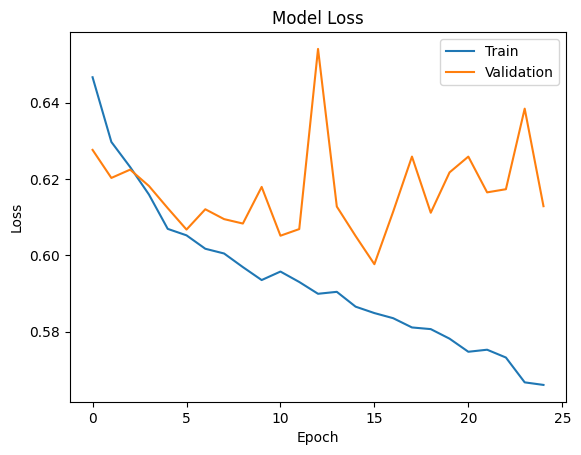

In [ ]:
graph_loss(m4_history)

In [ ]:
model5 = Sequential()
model5.add(LSTM(lstm_units, input_shape=(max_length, vector_size), return_sequences=True))
model5.add(LSTM(128, input_shape=(vector_size, 1), return_sequences=True))
model5.add(Dropout(0.1))
model5.add(LSTM(128, input_shape=(128, 1), return_sequences=True))
model5.add(Dropout(0.1))
model5.add(LSTM(32, input_shape=(128, 1), return_sequences=False))
model5.add(Dropout(0.3))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

m5_history = model5.fit(X_train, y_train,
                    batch_size=32,
                    epochs=25,
                    validation_split=0.2)

Epoch 1/25
191/191 [==============================] - 9s 21ms/step - loss: 0.6522 - accuracy: 0.6233 - val_loss: 0.6479 - val_accuracy: 0.6211
Epoch 2/25
191/191 [==============================] - 3s 13ms/step - loss: 0.6313 - accuracy: 0.6547 - val_loss: 0.6659 - val_accuracy: 0.5318
Epoch 3/25
191/191 [==============================] - 3s 13ms/step - loss: 0.6288 - accuracy: 0.6629 - val_loss: 0.6289 - val_accuracy: 0.6402
Epoch 4/25
191/191 [==============================] - 3s 13ms/step - loss: 0.6225 - accuracy: 0.6627 - val_loss: 0.6316 - val_accuracy: 0.6612
Epoch 5/25
191/191 [==============================] - 3s 14ms/step - loss: 0.6140 - accuracy: 0.6736 - val_loss: 0.6130 - val_accuracy: 0.6842
Epoch 6/25
191/191 [==============================] - 3s 14ms/step - loss: 0.6073 - accuracy: 0.6877 - val_loss: 0.6035 - val_accuracy: 0.6763
Epoch 7/25
191/191 [==============================] - 3s 13ms/step - loss: 0.6094 - accuracy: 0.6808 - val_loss: 0.6084 - val_accuracy: 0.6737

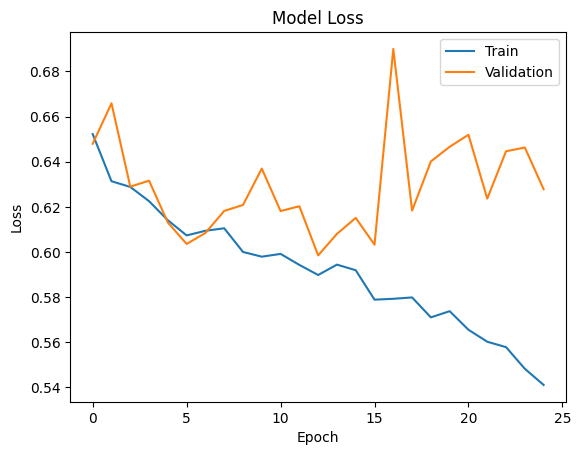

In [ ]:
graph_loss(m5_history)

## Conclusion & Analysis

This project aimed to develop a machine learning model for classifying tweets related to actual disasters, hypothetically for use by disaster relief organizations and news agencies monitoring Twitter. The approach utilized involved preprocessing the tweets with Twokenize and Word2Vec, followed by training an LSTM neural network. Despite the inherent challenges of interpreting the sometimes random language used on Twitter, the project suggests it is very possible.

The model achieved moderate success, indicating some ability to differentiate between disaster and non-disaster tweets, but I faced challenges with overfitting. The best performing model configuration, "Model 3", incorporated multiple LSTM layers and dropout layers with a 20% rate to mitigate this issue. Additional and stronger dropout layers seemed to have diminishing results.

Moving forward, exploring alternative machine learning models and techniques would be a recommended first step. Transformer-based models, such as BERT or GPT, could potentially offer better performance due to their advanced capabilities in understanding context. Additionally, data augmentation and more refined regularization techniques could improve the model's generalization.

### Appendix: Kaggle Competition Submission

In [ ]:
# Predict and output for test data
test_pred = model3.predict(X_test)
# test_targets = np.argmax(test_pred,axis=1)
test_targets = (test_pred > 0.5).astype("int32")

102/102 [==============================] - 1s 6ms/step


In [ ]:
# Reduce columns to just ids
submission_df = test_df.loc[:, test_df.columns.intersection(['id'])]
submission_df['target'] = test_targets
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df.sample(5)

,id,target
2006,6753,1
426,1377,0
1801,6081,0
1303,4287,0
1821,6157,0


In [ ]:
# Kaggle submission
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "DTSA-5511, v1 (0.5 threshold)"

100% 22.2k/22.2k [00:01<00:00, 14.6kB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (7.6 hours from now).


#### Resources and References

- Preprocessing Script for Crisis Data: Handles multiple cases found in the dataset such as URL fragments, Twitter specific syntax, and internet slang like ":)" and "lol". Available at: [CrisisNLP GitHub - preprocess.py](https://github.com/CrisisNLP/deep-learning-for-big-crisis-data/blob/master/data_helpers/preprocess.py).

- Tokenization documentation: [PyPI - Twokenize](https://pypi.org/project/twokenize/).

- Time Series Data Loading in Keras: Referenced for loading sequential data: [Keras Documentation](https://keras.io/api/data_loading/timeseries/).

- "Understanding LSTM and Its Implementation in Keras" was used as a basis for the model architecture: [Towards Data Science](https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47).

- Word2Vec Tutorial by TensorFlow was used when applying Word2Vec: [TensorFlow Word2Vec Tutorial](https://www.tensorflow.org/text/tutorials/word2vec).

- CrisisNLP Convolutional Neural Network (CNN) Script, an additional reference used when planning the model architecture: [CrisisNLP GitHub - cnn_crisis.py](https://github.com/CrisisNLP/deep-learning-for-big-crisis-data/blob/master/dnn_scripts/cnn_crisis.py).